In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re,json,nltk
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.metrics import classification_report,accuracy_score,precision_score,recall_score,f1_score
path ='/content/Dataset of male & female BD Cricketers.csv'
class color: # Text style
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

**Data preparation**

In [ ]:
# Read the data and take only 1000 Reviews
data = pd.read_csv('/content/Dataset of male & female BD Cricketers.csv',encoding='UTF-8')
data.head()

,Comment,Sentiment,Like,Haha,Angry,Love,Care,Sad,Wow
0,হায়রে ধান্দাবাজ \nপাবলিকের ইমোশন নিয়ে খেলা,Negative,103,420,89,8,2,4,0
1,আমি জানতাম এই রকম কিছু হবে কারণ বাংলাদেশের মা...,Neutral,43,161,0,2,1,0,0
2,জানতাম এটাই বলবেন,Neutral,4,6,0,0,0,0,0
3,নাটক তো ভালোই সিখছেন,Neutral,12,13,0,0,0,0,0
4,ভাই আমি তো বিকাশ চালাই,Positive,9,33,1,1,0,0,0


In [ ]:
print("Total Reviews:",len(data),
      "\nTotal  Positive Reviews:",len(data[data.Sentiment =='Positive']),
      "\nTotal Neutral Reviews:",len(data[data.Sentiment=='Neutral']),
      "\nTotal Negative Reviews:",len(data[data.Sentiment=='Negative']))

Total Reviews: 7083 
Total  Positive Reviews: 4571 
Total Neutral Reviews: 1363 
Total Negative Reviews: 1149


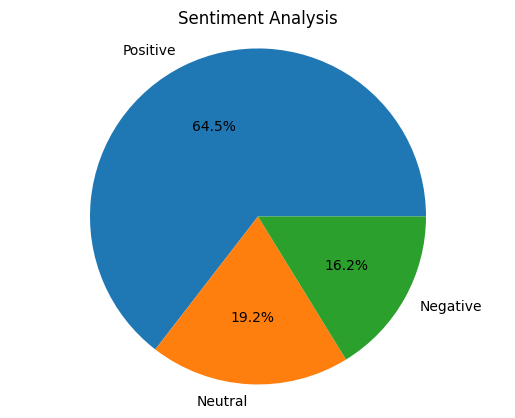

In [ ]:
data_sentiment = data[data['Sentiment'] == True]
sentiment_counts = data['Sentiment'].value_counts()
plt.pie(sentiment_counts.values, labels=sentiment_counts.index, autopct='%1.1f%%')
plt.title('Sentiment Analysis')
plt.axis('equal')  # Equal aspect ratio ensures that the pie chart is circular.
# Show the plot
plt.show()

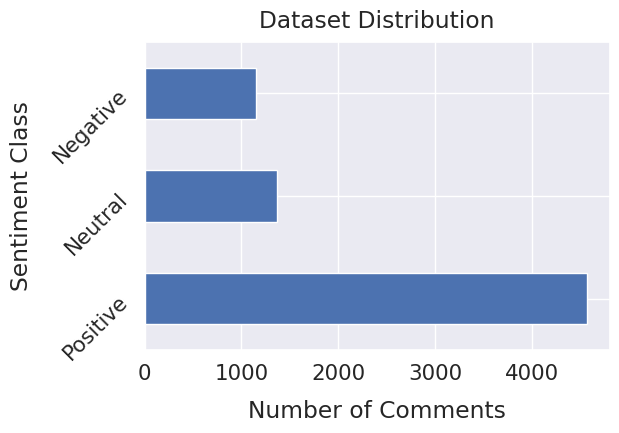

In [ ]:
sns.set(font_scale=1.4)
data['Sentiment'].value_counts().plot(kind='barh', figsize=(6, 4))
plt.xlabel("Number of Comments", labelpad=12)
plt.ylabel("Sentiment Class", labelpad=12)
plt.yticks(rotation = 45)
plt.title("Dataset Distribution", y=1.02);

In [ ]:
# print some unprocessed reviews
sample_data = [10,100,150,1300,]
for i in sample_data:
      print(data.Comment[i],'\n','Sentiment:-- ',data.Sentiment[i],'\n')

আর কত্ত খেলবো 
 Sentiment:--  Positive 

অভিনন্দন 
 Sentiment:--  Positive 

জানাচ্ছি 
 Sentiment:--  Positive 

ভাই জিতান এই ম্যাচ টা দয়া করে 
 Sentiment:--  Positive 



**Data cleaning**

In [ ]:
# Data cleaning function
def process_comments(comment):
    comment = re.sub('[^\u0980-\u09FF]',' ',str(comment)) #removing unnecessary punctuation
    return comment

In [ ]:
import pandas as pd
data['cleaned'] = ''
# Apply the function into the dataframe
data['cleaned'] = data['Comment'].apply(process_comments)

# print some cleaned reviews from the dataset
sample_data = [10,100,150,1300]
for i in sample_data:
     print('Original:\n',data.Comment[i],'\nCleaned:\n',
           data.cleaned[i],'\n','Sentiment:-- ',data.Sentiment[i],'\n')

Original:
 আর কত্ত খেলবো 
Cleaned:
 আর কত্ত খেলবো 
 Sentiment:--  Positive 

Original:
 অভিনন্দন 
Cleaned:
 অভিনন্দন 
 Sentiment:--  Positive 

Original:
 জানাচ্ছি 
Cleaned:
 জানাচ্ছি 
 Sentiment:--  Positive 

Original:
 ভাই জিতান এই ম্যাচ টা দয়া করে 
Cleaned:
 ভাই জিতান এই ম্যাচ টা দয়া করে 
 Sentiment:--  Positive 



**Remove Low lenght data**

In [ ]:
# Length of each Reveiws
data['length'] = data['cleaned'].apply(lambda x:len(x.split()))
# Remove the reviews with least words
dataset = data.loc[data.length>2]
dataset = dataset.reset_index(drop = True)
print("After Cleaning:","\nRemoved {} Small Reviews".format(len(data)-len(dataset)),
      "\nTotal Reviews:",len(dataset))


After Cleaning: 
Removed 926 Small Reviews 
Total Reviews: 6157


In [ ]:
import pickle
file = open('Dataset of male & female BD Cricketers.pkl', 'wb')
# dump information to that file
pickle.dump(data, file)

In [ ]:
# load the save file
data = open('Dataset of male & female BD Cricketers.pkl','rb')
data = pickle.load(data)

**Dataset summary**

In [ ]:
def data_summary(dataset):

    """
    This function will print the summary of the reviews and words distribution in the dataset.

    Args:
        dataset: list of cleaned sentences

    Returns:
        Number of documnets per class: int
        Number of words per class: int
        Number of unique words per class: int
    """
    documents = []
    words = []
    u_words = []
    total_u_words = [word.strip().lower() for t in list(dataset.cleaned) for word in t.strip().split()]
    class_label= [k for k,v in dataset.Sentiment.value_counts().to_dict().items()]
  # find word list
    for label in class_label:
        word_list = [word.strip().lower() for t in list(dataset[dataset.Sentiment==label].cleaned) for word in t.strip().split()]
        counts = dict()
        for word in word_list:
                counts[word] = counts.get(word, 0)+1
        # sort the dictionary of word list
        ordered = sorted(counts.items(), key= lambda item: item[1],reverse = True)
        # Documents per class
        documents.append(len(list(dataset[dataset.Sentiment==label].cleaned)))
        # Total Word per class
        words.append(len(word_list))
        # Unique words per class
        u_words.append(len(np.unique(word_list)))

        print("\nClass Name : ",label)
        print("Number of Documents:{}".format(len(list(dataset[dataset.Sentiment==label].cleaned))))
        print("Number of Words:{}".format(len(word_list)))
        print("Number of Unique Words:{}".format(len(np.unique(word_list))))
        print("Most Frequent Words:\n")
        for k,v in ordered[:10]:
              print("{}\t{}".format(k,v))
    print("Total Number of Unique Words:{}".format(len(np.unique(total_u_words))))

    return documents,words,u_words,class_label

#call the fucntion
documents,words,u_words,class_names = data_summary(dataset)



Class Name :  Positive
Number of Documents:3977
Number of Words:34502
Number of Unique Words:6262
Most Frequent Words:

ভাই	708
আপনার	359
না	341
ভালো	302
জন্য	301
অনেক	280
হবে	253
সাকিব	235
আপনি	230
আর	221

Class Name :  Neutral
Number of Documents:1143
Number of Words:10114
Number of Unique Words:3440
Most Frequent Words:

না	211
আমার	108
কি	106
করে	103
ভাই	95
আপু	95
এই	83
আপনার	83
আপনি	73
আমি	67

Class Name :  Negative
Number of Documents:1037
Number of Words:11803
Number of Unique Words:3690
Most Frequent Words:

না	273
ভাই	136
আর	119
করে	118
এই	91
আপনি	86
আপনার	78
থেকে	74
তামিম	72
কি	68
Total Number of Unique Words:9362


**Data visualization**

<ipython-input-15-46daabb39e01>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.xaxis.set_ticklabels(class_names, rotation=45);


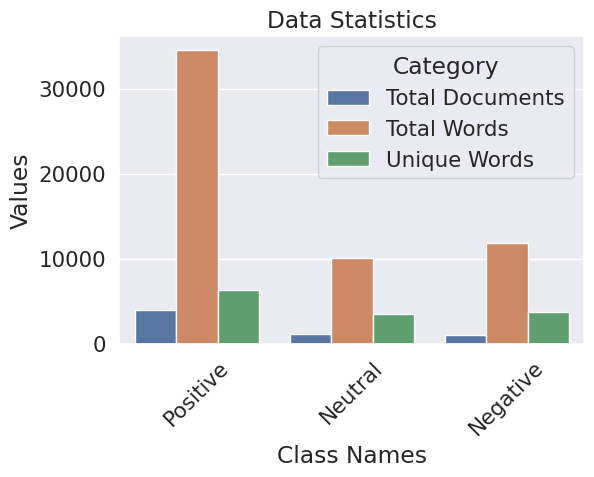

In [ ]:
data_matrix = pd.DataFrame({'Total Documents':documents,
                            'Total Words':words,
                            'Unique Words':u_words,
                            'Class Names':class_names})
df = pd.melt(data_matrix, id_vars="Class Names", var_name="Category", value_name="Values")
plt.figure(figsize=(6, 4))
ax = plt.subplot()

sns.barplot(data=df,x='Class Names', y='Values' ,hue='Category')
ax.set_xlabel('Class Names')
ax.set_title('Data Statistics')

ax.xaxis.set_ticklabels(class_names, rotation=45);

**Comment Lenght Distribution**

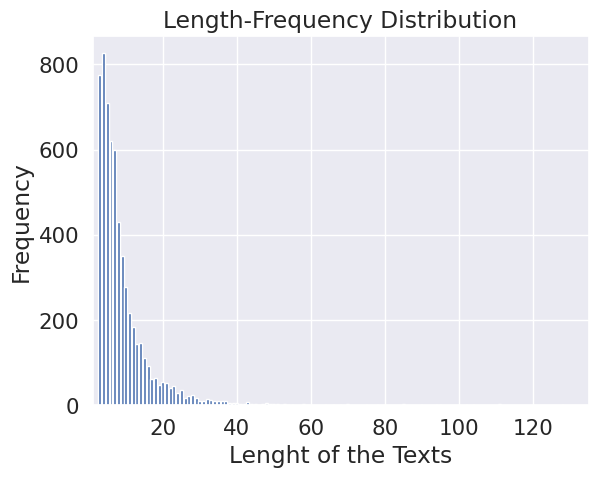

Maximum Length of a comment: 139
Minimum Length of a comment: 3
Average Length of a comment: 9.0


In [ ]:
# Calculate the Review of each of the Review
dataset['CommentLength'] = dataset.cleaned.apply(lambda x:len(x.split()))
frequency = dict()
for i in dataset.CommentLength:
    frequency[i] = frequency.get(i, 0)+1

plt.bar(frequency.keys(), frequency.values(), color ="b")
plt.xlim(1, 135)
# in this notbook color is not working but it should work.
plt.xlabel('Lenght of the Texts')
plt.ylabel('Frequency')
plt.title('Length-Frequency Distribution')
plt.show()
print(f"Maximum Length of a comment: {max(dataset.CommentLength)}")
print(f"Minimum Length of a comment: {min(dataset.CommentLength)}")
print(f"Average Length of a comment: {round(np.mean(dataset.CommentLength),0)}")

**Take only Positive and Negative Class for Model Building**

In [ ]:
dataset.Sentiment = dataset.Sentiment.replace({'Neutral':'Positive'})
positive = dataset[dataset.Sentiment == 'Positive']
negative = dataset[dataset.Sentiment == 'Negative'][:4000]
dataset = positive.append(negative,ignore_index=True)
dataset.Sentiment.value_counts()


<ipython-input-17-4b66a9ca1beb>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = positive.append(negative,ignore_index=True)


Positive    5120
Negative    1037
Name: Sentiment, dtype: int64

**Lable Encoding and Dataset Splitting**

In [ ]:

                                       ################# Label Encoding Function #########


def label_encoding(sentiment,bool):
    """
    This function will return the encoded labels in array format.

    Args:
        sentiment: series of class names(str)
        bool: boolean (True or False)

    Returns:
        labels: numpy array
    """
    le = LabelEncoder()
    le.fit(sentiment)
    encoded_labels = le.transform(sentiment)
    labels = np.array(encoded_labels) # Converting into numpy array
    class_names =le.classes_ ## Define the class names again
    if bool == True:
        print("\n\t\t\t===== Label Encoding =====","\nClass Names:-->",le.classes_)
        for i in sample_data:
            print(sentiment[i],' ', encoded_labels[i],'\n')

    return labels




                           ################# Dataset Splitting Function ###############


def dataset_split(feature_space,sentiment):
    """
    This function will return the splitted (80%-20%) feature vector .

    Args:
        feature_space: calcuated feature vector (sparse matrix)
        sentiment: encoded lables (array)

    Returns:
        X_train: training feature vector (sparse matrix)
        X_test : testing feature vector (sparse matrix)
        y_train: training encoded labels (array)
        y_test : testing encoded labels (array)
    """

    X_train,X_test,y_train,y_test = train_test_split(feature_space,sentiment,train_size = 0.9,
                                                  test_size = 0.1,random_state =0)
    print("Feature Size :======>",X_train.shape[1])
    print("\nDataset Distribution:\n")
    print("\tSet Name","\t\tSize")
    print("\t========\t\t======")

    print("\tFull\t\t\t",feature_space.shape[0],
        "\n\tTraining\t\t",X_train.shape[0],
        "\n\tTest\t\t\t",X_test.shape[0])

    return X_train,X_test,y_train,y_test
dataset.cleaned = dataset.cleaned.apply(lambda x:x.replace('\n',' '))

**Model Building       *Feature Extraction Using TF-IDF**

In [ ]:

                                            ##### Unigram Tf-idf value calculation


def calc_gram_tfidf(reviews,gram):
    """
    This function will return the tf-idf value of the respective gram features .

    Args:
        reviews: a list of cleaned reviews

    Returns:
        tfidf: a instance of TfidfVectorizer
        X : Unigram Feature Vector (sparse matrix)
    """
    tfidf = TfidfVectorizer(ngram_range=gram,use_idf=True,tokenizer=lambda x: x.split())
    X = tfidf.fit_transform(reviews)
    return tfidf,X

In [ ]:
import pickle
with open('tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(TfidfVectorizer, f)

In [ ]:
# load the save file
data = open('tfidf_vectorizer.pkl','rb')
data = pickle.load(data)

****

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report,accuracy_score,precision_score,recall_score,f1_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import average_precision_score,roc_auc_score, roc_curve, precision_recall_curve

In [ ]:

                                              #########  Classifiers Defination  #########

def ml_models_defination():
    """
    This function consists the models defination for All gram Features

    Retuns:
        ml_models: list of models
        model_names: list of model_names

    """

    lr_model = LogisticRegression(random_state = 123)
    dt_model = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
    rf_model = RandomForestClassifier(n_estimators=100, criterion ='entropy', random_state = 0)
    knn_model = KNeighborsClassifier(n_neighbors=3, metric = 'minkowski')
    lsvm_model = SVC(kernel = 'linear',C = 0.2, probability=True, random_state = 0)
    xgboost_model= XGBClassifier(n_estimators=100, learning_rate=0.01)
    adabost_model=AdaBoostClassifier()
    ann_model=MLPClassifier()

    model_names = ['Logistic Regression','Decision Tree','Random Forest','KNN','Linear SVM','XGBoost','Adabost','ANN']
    #model_names = ['Logistic Regression']
    # Create list of models
    ml_models = [lr_model,dt_model,rf_model,knn_model,lsvm_model,xgboost_model,adabost_model,ann_model]
    #ml_models = [lr_model]
    return ml_models,model_names



                                           ####### Model Evaluation Function ############


def model_performace(model,X_train,X_test,y_train,y_test):
    """
    This function will return the performance parameter values of each ML models.
    Performance parameters are Accuracy, F1-Score, Precision, Recall.

    Args:
        model: a ML model instance
        X_train: training feature vector (sparse matrix)
        X_test : testing feature vector (sparse matrix)
        y_train: training encoded labels (array)
        y_test : testing encoded labels (array)

    Returns:
        my_dict: a dictionary of all the parameters for each models
    """
    my_dict = {}
    model.fit(X_train,y_train)
    # Prediction
    pred_y = model.predict(X_test)
    my_dict['Accuracy'] = round(accuracy_score(y_test, pred_y),4)*100
    my_dict['Precision'] = round(precision_score(y_test, pred_y),4)*100
    my_dict['Recall'] = round(recall_score(y_test, pred_y),4)*100
    my_dict['F1 Score'] = round(f1_score(y_test, pred_y),4)*100

    return my_dict


                                        #### Model Performane into Dataframe #####


def performance_table(performance_dict):
    """
    This function will create a dataframe of all the performance parameters.

    Args:
        performance_dict: a dictionary of all the parameters for each models

    Returns:
        performance_df: a dataframe
    """

    acc_list = []
    pr_list = []
    re_list = []
    f1_list = []
    for i in performance_dict.keys():
        acc_list.append(performance_dict[i]['Accuracy'])
        pr_list.append(performance_dict[i]['Precision'])
        re_list.append(performance_dict[i]['Recall'])
        f1_list.append(performance_dict[i]['F1 Score'])

    # Create a dataframe
    model_names = ['LR','DT','RF','KNN','Linear SVM','XGBoost','Adabost','ANN']
    performance_df = pd.DataFrame({'Accuracy':acc_list,'Precision':pr_list,
                                   'Recall':re_list,'F1 Score':f1_list,
                                   'Model Name':model_names })
    return performance_df

**Model Training**

In [ ]:
## save the performance of the model for each gram feature
gram_names = ['Unigram','Bigram','Trigram']
ngrams = [(1,1),(1,2),(1,3)]
for i,gram in enumerate(ngrams):
    tfidf,feature = calc_gram_tfidf(dataset.cleaned,gram)
    labels = label_encoding(dataset.Sentiment,False)
    X_train,X_test,y_train,y_test = dataset_split(feature,labels)
    ml_models,model_names = ml_models_defination()
    # call model accuracy function and save the metrices into a dictionary
    accuracy = {f'{model_names[j]}':model_performace(model,X_train,X_test,y_train,y_test) for j,model in enumerate(ml_models)}
    #Save the performance parameter into json file
    with open(path+f'ml_performance_{gram_names[i]}.json', 'w') as f:
          json.dump(accuracy, f)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Feature Size :======> 9362

Dataset Distribution:

	Set Name 		Size
	========		======
	Full			 6157 
	Training		 5541 
	Test			 616


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Feature Size :======> 45251

Dataset Distribution:

	Set Name 		Size
	========		======
	Full			 6157 
	Training		 5541 
	Test			 616


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Feature Size :======> 84693

Dataset Distribution:

	Set Name 		Size
	========		======
	Full			 6157 
	Training		 5541 
	Test			 616


In [ ]:
# Load all the json files
gram_names = ['Unigram','Bigram','Trigram']

for gram in gram_names:
  accuracy = json.load(open(path+f'ml_performance_{gram}.json'))
  table = performance_table(accuracy)
  print(f"\n========== Performace Table for {gram} feature:========\n",table)
  print(f"\n========In case of {gram} feature:========\n")
  print(f"Highest Accuracy achieved by {table['Model Name'][table.Accuracy.idxmax(axis = 0)]} at = {max(table.Accuracy)}")
  print(f"Highest F1-Score achieved by {table['Model Name'][table['F1 Score'].idxmax(axis = 0)]} at = {max(table['F1 Score'] )}")
  print(f"Highest Precision Score achieved by {table['Model Name'][table['Precision'].idxmax(axis = 0)]} at = {max(table['Precision'] )}")
  print(f"Highest Recall Score achieved by {table['Model Name'][table['Recall'].idxmax(axis = 0)]} at = {max(table['Recall'] )}")



========== Performace Table for Unigram feature:========
    Accuracy  Precision  Recall  F1 Score  Model Name
0     86.04      86.02   99.81     92.40          LR
1     82.95      88.87   91.41     90.12          DT
2     85.39      86.29   98.47     91.98          RF
3     86.85      88.39   97.33     92.64         KNN
4     85.39      85.34  100.00     92.09  Linear SVM
5     85.55      85.60   99.81     92.16     XGBoost
6     85.71      87.20   97.52     92.07     Adabost
7     83.44      89.66   91.03     90.34         ANN

========In case of Unigram feature:========

Highest Accuracy achieved by KNN at = 86.85000000000001
Highest F1-Score achieved by KNN at = 92.64
Highest Precision Score achieved by ANN at = 89.66
Highest Recall Score achieved by Linear SVM at = 100.0

========== Performace Table for Bigram feature:========
    Accuracy  Precision  Recall  F1 Score  Model Name
0     85.55      85.48  100.00     92.17          LR
1     81.49      88.68   89.69     89.18        

<ipython-input-26-389ab4bc206e>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.xaxis.set_ticklabels(table['Model Name'], rotation=45);
<ipython-input-26-389ab4bc206e>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.xaxis.set_ticklabels(table['Model Name'], rotation=45);
<ipython-input-26-389ab4bc206e>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.xaxis.set_ticklabels(table['Model Name'], rotation=45);


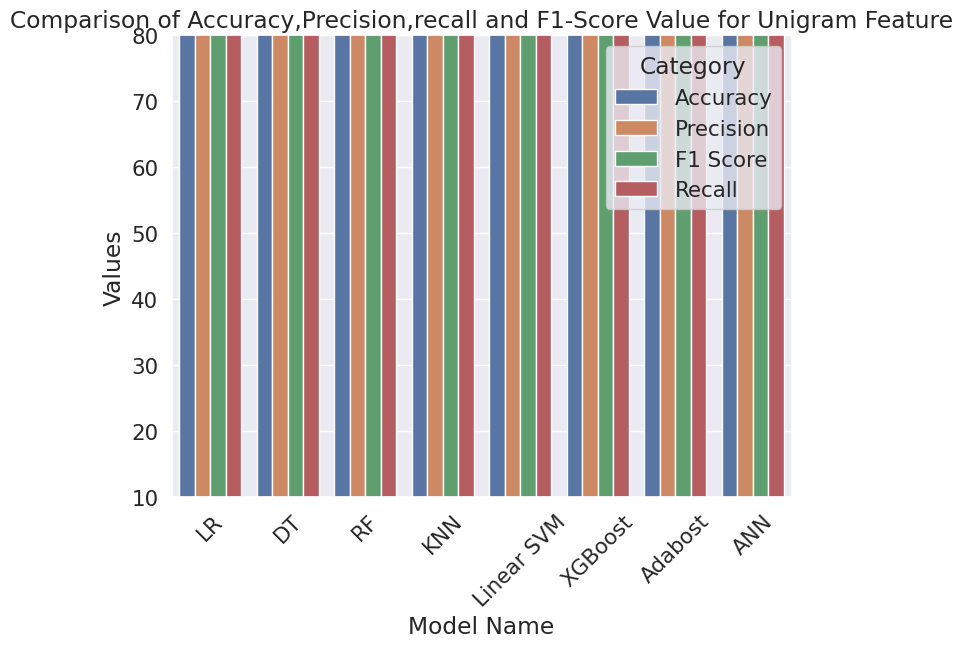

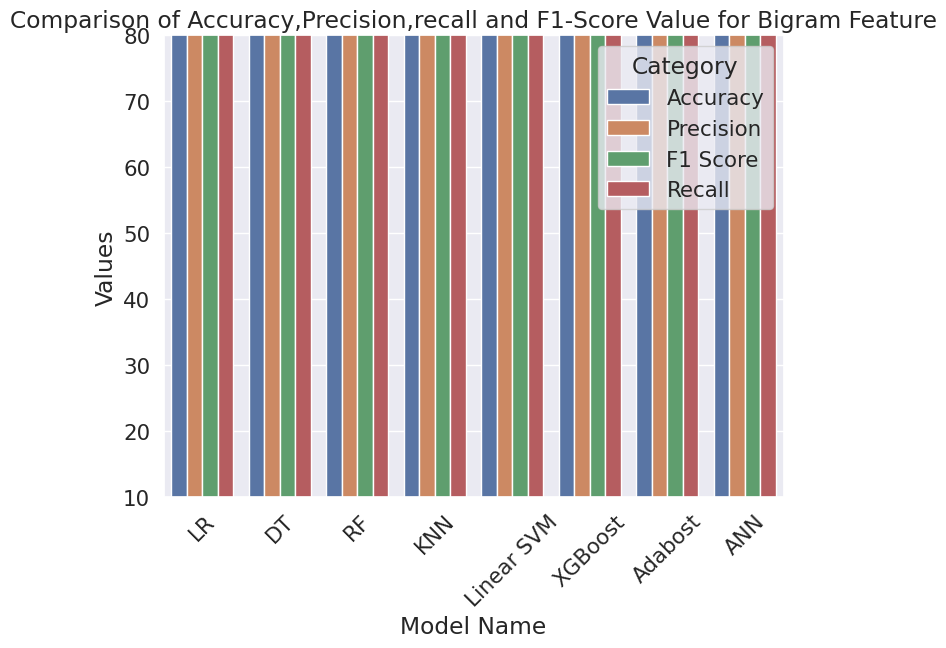

In [ ]:
gram_names = ['Unigram','Bigram','Trigram']

for gram in gram_names:
  accuracy = json.load(open(path+f'ml_performance_{gram}.json'))
  table = performance_table(accuracy)
  df = pd.melt(table[['Accuracy','Precision','F1 Score','Recall','Model Name']], id_vars="Model Name", var_name="Category", value_name="Values")
  plt.figure(figsize=(8,6))
  ax = plt.subplot()
  sns.barplot(data=df,x='Model Name', y='Values' ,hue='Category')
  ax.set_xlabel('Model Name')
  ax.set_title(f'Comparison of Accuracy,Precision,recall and F1-Score Value for {gram} Feature')
  ax.set_ylim([10,80])
  ax.xaxis.set_ticklabels(table['Model Name'], rotation=45);

Confusion Matrix for Logistic Regression:


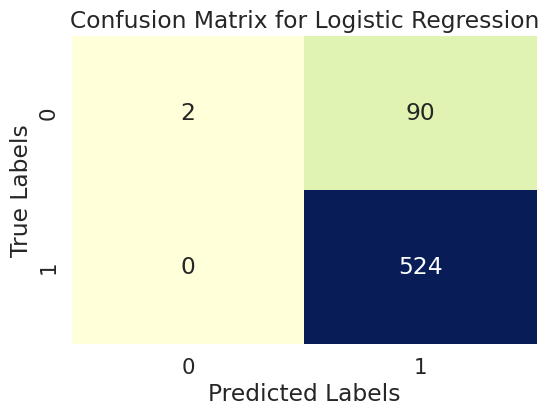

Confusion Matrix for Decision Tree:


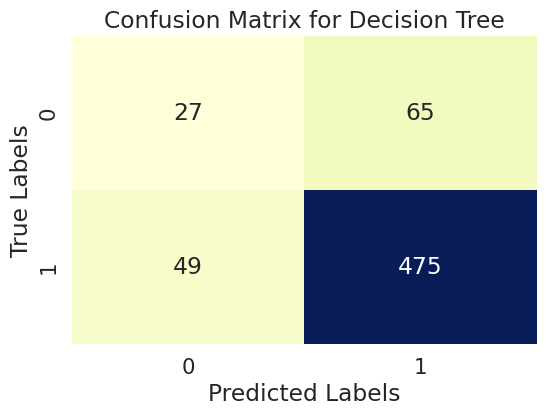

Confusion Matrix for Random Forest:


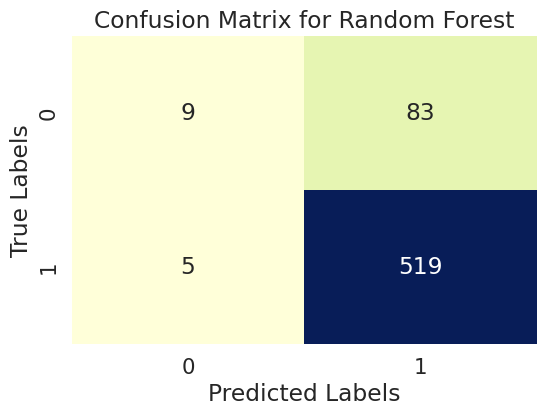

Confusion Matrix for KNN:


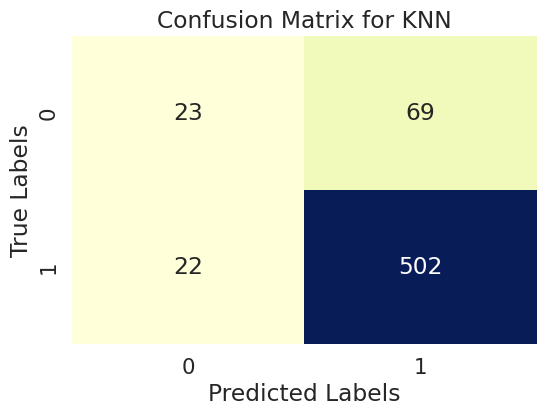

Confusion Matrix for Linear SVM:


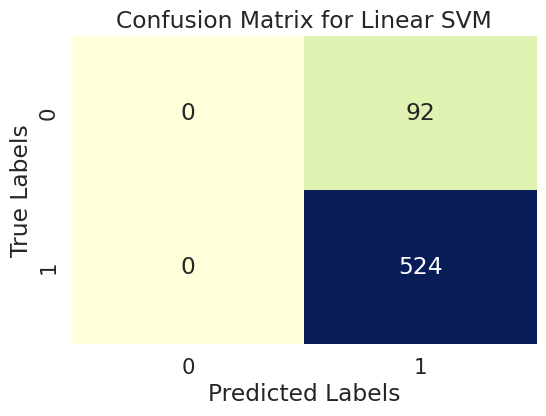

Confusion Matrix for XGBoost:


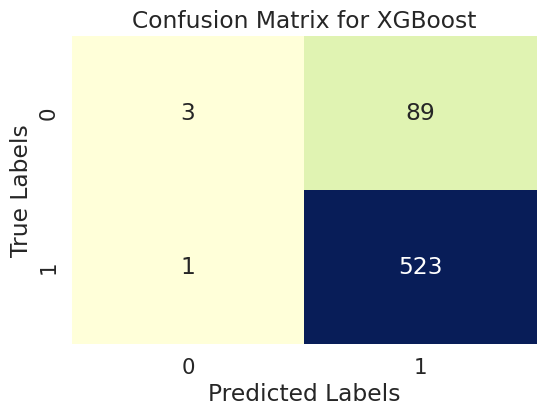

Confusion Matrix for Adabost:


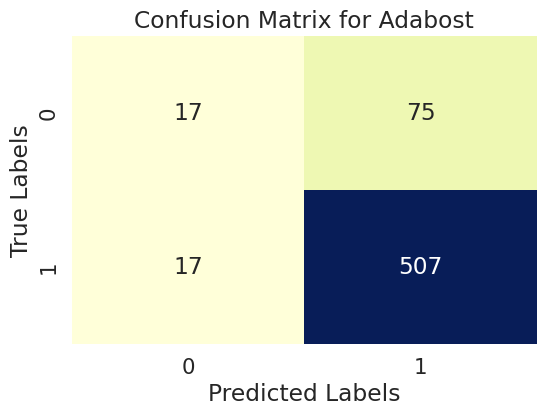

Confusion Matrix for ANN:


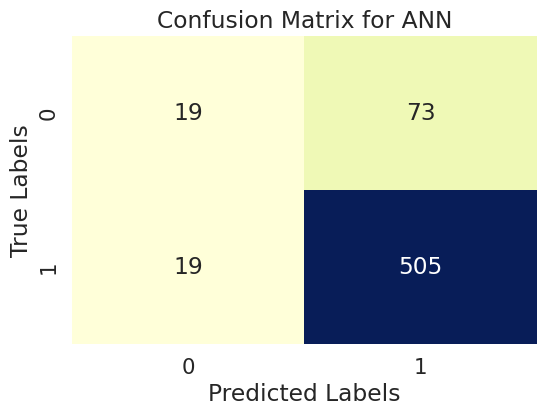

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def model_performace(model,X_train,X_test,y_train,y_test):
    """
    This function will return the performance parameter values of each ML models.
    Performance parameters are Accuracy, F1-Score, Precision, Recall and Confusion Matrix.

    Args:
        model: a ML model instance
        X_train: training feature vector (sparse matrix)
        X_test : testing feature vector (sparse matrix)
        y_train: training encoded labels (array)
        y_test : testing encoded labels (array)

    Returns:
        my_dict: a dictionary of all the parameters for each models
    """
    my_dict = {}
    model.fit(X_train,y_train)
    # Prediction
    pred_y = model.predict(X_test)
    my_dict['Accuracy'] = round(accuracy_score(y_test, pred_y),4)*100
    my_dict['Precision'] = round(precision_score(y_test, pred_y),4)*100
    my_dict['Recall'] = round(recall_score(y_test, pred_y),4)*100
    my_dict['F1 Score'] = round(f1_score(y_test, pred_y),4)*100
    my_dict['Confusion Matrix'] = confusion_matrix(y_test, pred_y)

    return my_dict

# Inside the main loop where you're iterating over models and grams, modify the following section

accuracy = {f'{model_names[j]}':model_performace(model,X_train,X_test,y_train,y_test) for j,model in enumerate(ml_models)}

# After this loop, you can visualize the confusion matrix

# Visualizing confusion matrix for each model
for model_name, model_accuracy in accuracy.items():
    print(f"Confusion Matrix for {model_name}:")
    plt.figure(figsize=(6, 4))
    sns.heatmap(model_accuracy['Confusion Matrix'], annot=True, cmap="YlGnBu", fmt="d", cbar=False)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()

**Check a sentiment using our trained model**

In [ ]:
import pickle
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import re

# Load the trained models
model_files = {
    'Logistic Regression': '/content/ml_performance_Bigram.json',
    'Decision Tree': '/content/ml_performance_Bigram.json',
    'Random Forest': '/content/ml_performance_Bigram.json',
    'KNN':'/content/ml_performance_Bigram.json',
    'Linear SVM': '/content/ml_performance_Bigram.json',
    'XGBoost': '/content/ml_performance_Bigram.json',
    'Adabost': '/content/ml_performance_Bigram.json',
    'ANN': '/content/ml_performance_Bigram.json'
}

models = {}
for model_name, file_path in model_files.items():
    # Load the trained model from the saved pickle files
    try:
        with open(file_path, 'rb') as f:
            models[model_name] = pickle.load(f)
    except (pickle.UnpicklingError, IOError) as e:
        print("Error loading model:", e)

# Load the vectorizer
try:
    with open('/content/tfidf_vectorizer.pkl', 'rb') as f:
        tfidf = pickle.load(f)
except (pickle.UnpicklingError, IOError) as e:
    print("Error loading vectorizer:", e)

# Preprocess text data
def process_comments(comment):
    comment = re.sub('[^\u0980-\u09FF]', ' ', str(comment))  # removing unnecessary punctuation
    return comment

def predict_sentiment(comment, model_name):
    # Load the trained model
    model = models[model_name]

    # Preprocess the comment
    cleaned_comment = process_comments(comment)

    # Transform the preprocessed text data using the same vectorizer used during training
    transformed_comment = tfidf.transform([cleaned_comment])

    # Predict the sentiment label
    prediction = model.predict(transformed_comment)

    return prediction[0]

def aggregate_predictions(predictions):
    # You can implement different aggregation strategies here, such as majority voting or averaging probabilities
    # For simplicity, we'll use majority voting
    positive_count = sum(1 for pred in predictions if pred == 'Positive')
    negative_count = sum(1 for pred in predictions if pred == 'Negative')
    negative_count = sum(1 for pred in predictions if pred == 'Neutral')
    if positive_count > negative_count:
        return 'Positive'
    elif positive_count < negative_count:
        return 'Negative'
    else:
        return 'Neutral'



# Example usage
comment = " অভিনন্দন "
predictions = []
for model_name in models.keys():
    prediction = predict_sentiment(comment, model_name)
    predictions.append(prediction)

final_sentiment = aggregate_predictions(predictions)
print(f"Final sentiment for the comment: {final_sentiment}")

Error loading model: invalid load key, '{'.
Error loading model: invalid load key, '{'.
Error loading model: invalid load key, '{'.
Error loading model: invalid load key, '{'.
Error loading model: invalid load key, '{'.
Error loading model: invalid load key, '{'.
Error loading model: invalid load key, '{'.
Error loading model: invalid load key, '{'.
Final sentiment for the comment: Neutral
